# Alpha Model Improvements: Multi-day Forward-Return Target (K-day Ridge OOS)

This notebook extends the baseline workflow by changing only the prediction target:
**predict K-day forward returns instead of 1-day returns**.

Motivation:
- Daily (1-day) cross-sectional returns are extremely noisy.
- Many simple factors are expected to express more clearly over multi-day horizons.
- This is a structural change (target definition), not hyperparameter tuning.

We compare:
- Baseline Ridge OOS with 1-day target
- Ridge OOS with K-day target (K = 5 by default)

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import EquityDataLoader, DataConfig
from src.factors import FactorCalculator, FactorConfig, zscore_cross_section
from src.alpha_model import AlphaModelOOSRidge, AlphaModelOOSRidgeKDay

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

## 1. Universe and sample period

In [2]:
sp500_path = ROOT / "data" / "universe" / "sp500.csv"

def load_sp500_tickers(path: Path) -> list[str]:
    df = pd.read_csv(path)
    if "Symbol" not in df.columns:
        raise ValueError("sp500.csv must contain a 'Symbol' column.")
    return (
        df["Symbol"].astype(str).str.strip().str.replace(".", "-", regex=False)
        .dropna().unique().tolist()
    )

universe = load_sp500_tickers(sp500_path)
start = "2010-01-01"
end = "2024-12-31"

## 2. Load adjusted close prices

In [3]:
data_cfg = DataConfig()
loader = EquityDataLoader(project_root=ROOT, config=data_cfg)

prices = loader.load_adjusted_close(
    tickers=universe,
    start=start,
    end=end,
    interval="1d",
    force_refresh=False,
)

prices.tail()

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


[DataLoader] Skipping WBA: Downloaded empty DataFrame for ticker WBA.


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,...,WRB,GWW,WAB,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WY,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-23,126.589973,67.177307,112.184288,172.363205,353.719879,446.739990,124.599998,12.304317,100.531624,133.516983,286.256195,134.520004,96.599998,87.650490,93.018967,207.570007,131.106903,57.384167,189.902512,193.870728,195.229950,49.940449,225.059998,9.183184,87.134323,...,57.798267,1072.735474,190.486176,89.675789,110.926964,10.44,200.811218,369.760010,91.717125,69.039757,123.454231,328.502686,46.352802,27.177324,183.727386,52.675449,310.858765,265.390015,87.261322,65.543053,116.122368,131.317734,390.649994,105.818138,162.125519
2024-12-24,127.944412,67.500648,112.625923,173.918808,356.539642,447.940002,126.290001,12.266631,101.020866,135.004929,288.664795,134.990005,96.910004,88.426765,93.517395,213.500000,132.009857,57.732777,191.756134,195.344940,196.803833,49.837914,229.050003,9.241613,88.300125,...,58.095131,1081.298828,193.182526,91.988411,112.082031,10.55,202.368073,373.149994,91.910545,70.067413,124.407509,331.692291,46.458221,27.351536,184.919266,53.211460,312.490295,269.040009,87.924866,66.017303,116.754807,132.436081,395.440002,106.293640,162.539993
2024-12-26,128.749207,67.500648,113.126434,173.145828,355.356537,450.160004,125.059998,12.097046,101.431854,134.737091,287.748169,135.320007,97.959999,87.601364,93.705467,215.500000,131.960251,57.761826,191.854187,194.836945,196.335663,49.980442,227.050003,9.212399,88.105827,...,58.599792,1073.022949,192.884033,92.097588,112.072083,10.62,202.013336,376.779999,91.746147,70.233810,124.210960,332.350159,46.465744,27.264429,184.820770,52.587742,314.309692,269.380005,88.449760,65.988274,117.071037,133.417099,396.850006,106.244102,163.349258
2024-12-27,127.767731,67.049927,112.851646,171.996033,351.166321,446.480011,125.190002,12.012254,101.157860,134.449417,285.534576,133.384995,96.970001,86.756302,92.492310,211.429993,130.948135,57.655304,190.069244,192.008011,193.287506,49.771404,223.750000,9.192922,87.552071,...,58.352406,1059.494141,191.033401,90.976021,111.076332,10.61,201.028015,374.600006,91.697800,69.597633,122.844917,332.140839,45.705246,27.090216,183.264420,52.568245,312.767151,266.239990,87.825829,65.949562,116.142136,132.661728,389.070007,105.867676,162.441315
2024-12-30,126.737213,66.648193,110.702377,170.247192,347.528290,445.799988,122.440002,11.918040,100.756676,133.338425,281.516968,131.809998,95.559998,84.643646,91.975067,206.580002,129.955872,57.451954,188.843307,190.493942,191.942764,49.486343,221.300003,9.095539,87.066322,...,57.907120,1048.819580,189.988678,89.894157,110.329514,10.51,199.303680,370.940002,91.107872,68.912521,122.766312,327.755096,44.892040,26.993431,183.717514,52.782650,309.731537,262.000000,85.003288,65.417229,114.906891,130.984192,383.850006,104.646461,160.112274


## 3. Factor construction and cross-sectional z-scoring

In [4]:
factor_cfg = FactorConfig(
    ret_lag=1,
    momentum_windows=[21, 63, 252],
    volatility_windows=[21, 63],
    include_short_term_reversal=True,
    reversal_window=5,
    include_vol_of_vol=True,
    vov_windows=[21, 63],
    include_vol_adj_momentum=True,
    vol_adj_mom_pairs=[(21, 21), (63, 63), (252, 63)],
)

factor_calc = FactorCalculator(factor_cfg)
factor_panel = factor_calc.build_factor_panel(prices)
zpanel = zscore_cross_section(factor_panel)

factor_columns = list(zpanel.columns)

## 4. Fit baseline Ridge (1-day) vs K-day Ridge

We keep the same training protocol and only change the forward-return horizon.

In [ ]:
ridge_lambda = 10.0
lookback_days = 60
min_history_days = 40
min_stocks = 50

baseline = AlphaModelOOSRidge(
    factor_columns=factor_columns,
    lookback_days=lookback_days,
    min_history_days=min_history_days,
    min_stocks=min_stocks,
    ridge_lambda=ridge_lambda,
)

K = 5
kday = AlphaModelOOSRidgeKDay(
    factor_columns=factor_columns,
    lookback_days=lookback_days,
    min_history_days=min_history_days,
    min_stocks=min_stocks,
    ridge_lambda=ridge_lambda,
    horizon_days=K,
)

res_base = baseline.fit(zpanel, prices)
res_k = kday.fit(zpanel, prices)

ic_base = res_base["ic"]
ic_base = ic_base["ic"] if isinstance(ic_base, pd.DataFrame) else ic_base
ic_base = ic_base.dropna().rename("IC_1d")

ic_k = res_k["ic"]
ic_k = ic_k["ic"] if isinstance(ic_k, pd.DataFrame) else ic_k
ic_k = ic_k.dropna().rename(f"IC_{K}d")

## 5. IC comparison

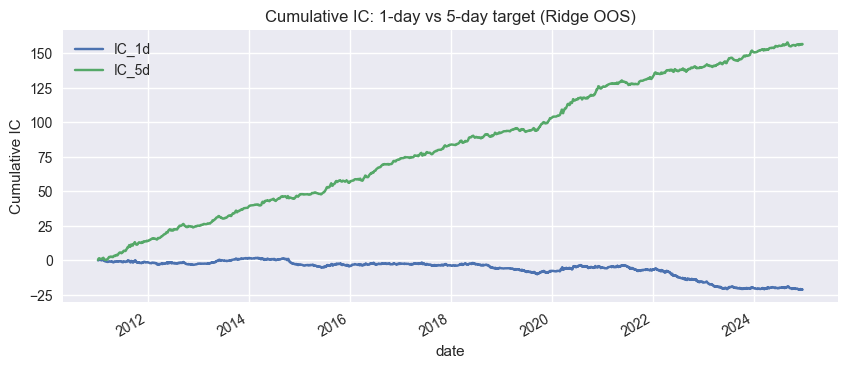

,MeanIC,ICtStat,N
Ridge_1d,-0.006717,-2.214093,3151.0
Ridge_5d,0.049718,16.632386,3151.0


In [6]:
ic_compare = pd.concat([ic_base, ic_k], axis=1, join="inner").dropna()

ax = ic_compare.cumsum().plot(figsize=(10, 4))
ax.set_title(f"Cumulative IC: 1-day vs {K}-day target (Ridge OOS)")
ax.set_ylabel("Cumulative IC")
ax.grid(True)
plt.show()

def ic_summary(s: pd.Series) -> pd.Series:
    s = s.dropna()
    mu = s.mean()
    sd = s.std()
    t = mu / sd * np.sqrt(len(s)) if sd > 0 else np.nan
    return pd.Series({"MeanIC": mu, "ICtStat": t, "N": float(len(s))})

pd.DataFrame(
    [ic_summary(ic_compare["IC_1d"]), ic_summary(ic_compare[f"IC_{K}d"])],
    index=["Ridge_1d", f"Ridge_{K}d"],
)

## Interpretation

Changing the prediction target from 1-day to 5-day forward returns produces a
substantial improvement in cross-sectional predictability.

The 1-day Ridge model exhibits a slightly negative mean IC, consistent with
microstructure noise dominating daily returns. In contrast, the 5-day target
yields a strongly positive mean IC with a t-statistic above 16 over more than
3,000 trading days.

This result suggests that the factor set contains genuine cross-sectional
information, but that the information is expressed over multi-day horizons
rather than at the daily frequency.

Importantly, this improvement arises from a structural modeling decision
(target definition) rather than parameter tuning or factor selection.